In [1]:
from PIL import Image
import numpy as np
import os
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import random
from math import log
from google.colab.patches import cv2_imshow
from tqdm import tqdm

def binary_to_decimal(bit_sequence):
    decimal_value = 0

    for bit in bit_sequence:
        decimal_value = decimal_value * 2 + int(bit)

    return decimal_value

def load_image_matrix(image_path):
    image = Image.open(image_path)
    pixel_data = image.load()
    is_color = 1

    if type(pixel_data[0, 0]) == int:
        is_color = 0

    image_size = image.size
    image_array = []

    for width in range(int(image_size[0])):
        row = []

        for height in range(int(image_size[1])):
            row.append(pixel_data[width, height])

        image_array.append(row)

    return image_array, image_size[0], image_size[1], is_color

def generate_custom_map(dimension, key):
    x_val = key[0]
    y_val = key[1]
    sequence_size = dimension * dimension * 8  # Total Number of bit sequences produced
    bit_sequence = []    # Each bit sequence contains 8 bits
    byte_array = []      # Each byte array contains m (i.e., 512 in this case) bit sequences
    result_matrix = []   # Each result matrix contains m*n byte arrays (i.e., 512 byte arrays in this case)

    for i in range(sequence_size):
        x_n = y_val + 1 - 1.4 * x_val**2
        y_n = 0.3 * x_val

        x_val = x_n
        y_val = y_n

        if x_n <= 0.4:
            bit = 0
        else:
            bit = 1

        try:
            bit_sequence.append(bit)
        except:
            bit_sequence = [bit]

        if i % 8 == 7:
            decimal = binary_to_decimal(bit_sequence)
            try:
                byte_array.append(decimal)
            except:
                byte_array = [decimal]
            bit_sequence = []

        byte_array_size = dimension * 8
        if i % byte_array_size == byte_array_size - 1:
            try:
                result_matrix.append(byte_array)
            except:
                result_matrix = [byte_array]
            byte_array = []

    return result_matrix

def encrypt_image(input_image_name, security_key):
    image_data, dim_x, dim_y, is_colored = load_image_matrix(input_image_name)
    transformation_matrix = generate_custom_map(dim_x, security_key)
    encrypted_matrix = []

    for i in range(dim_x):
        row = []

        for j in range(dim_y):
            try:
                if is_colored:
                    row.append(tuple([transformation_matrix[i][j] ^ x for x in image_data[i][j]]))
                else:
                    row.append(transformation_matrix[i][j] ^ image_data[i][j])
            except:
                if is_colored:
                    row = [tuple([transformation_matrix[i][j] ^ x for x in image_data[i][j]])]
                else:
                    row = [transformation_matrix[i][j] ^ x for x in image_data[i][j]]

        try:
            encrypted_matrix.append(row)
        except:
            encrypted_matrix = [row]

    if is_colored:
        im = Image.new("RGB", (dim_x, dim_y))
    else:
        im = Image.new("L", (dim_x, dim_y))  # L is for black and white pixels

    pix = im.load()

    for x in range(dim_x):
        for y in range(dim_y):
            pix[x, y] = encrypted_matrix[x][y]

    im.save("encrypted.png", "PNG")

def decrypt_encrypted_image(encrypted_image_name, security_key):
    encrypted_data, dim_x, dim_y, is_colored = load_image_matrix(encrypted_image_name)
    transformation_matrix = generate_custom_map(dim_x, security_key)
    pil_im = Image.open(encrypted_image_name, 'r')
    imshow(np.asarray(pil_im))
    decrypted_image = []

    for i in range(dim_x):
        row = []

        for j in range(dim_y):
            try:
                if is_colored:
                    row.append(tuple([transformation_matrix[i][j] ^ x for x in encrypted_data[i][j]]))
                else:
                    row.append(transformation_matrix[i][j] ^ encrypted_data[i][j])
            except:
                if is_colored:
                    row = [tuple([transformation_matrix[i][j] ^ x for x in encrypted_data[i][j]])]
                else:
                    row = [transformation_matrix[i][j] ^ x for x in encrypted_data[i][j]]

        try:
            decrypted_image.append(row)
        except:
            decrypted_image = [row]

    if is_colored:
        im = Image.new("RGB", (dim_x, dim_y))
    else:
        im = Image.new("L", (dim_x, dim_y))  # L is for black and white pixels

    pix = im.load()

    for x in range(dim_x):
        for y in range(dim_y):
            pix[x, y] = decrypted_image[x][y]

    im.save( "decrypted.png", "PNG")


In [2]:
image = "original_image.jpg"
key = (0.2,0.2)

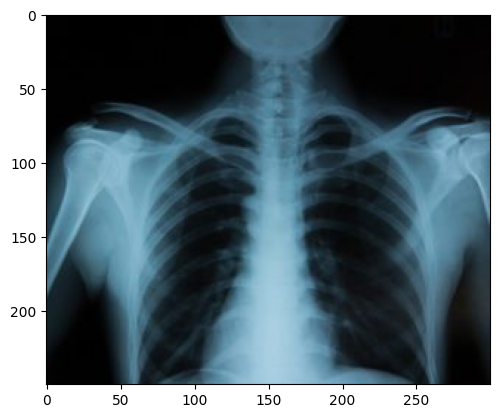

In [3]:
pil_im = Image.open(image, 'r')
imshow(np.asarray(pil_im))

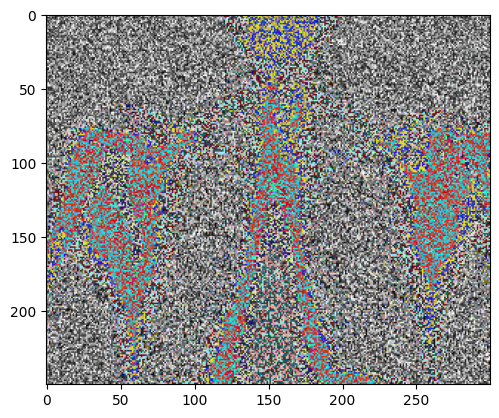

In [4]:
encrypt_image(image, key)
im = Image.open("encrypted.png", 'r')
imshow(np.asarray(im))

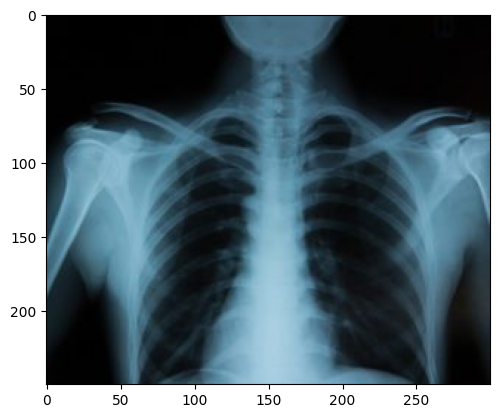

In [5]:
decrypt_encrypted_image("encrypted.png", key)
im = Image.open("decrypted.png", 'r')
imshow(np.asarray(im))

In [6]:
import numpy as np
from skimage import io
from skimage.measure import shannon_entropy

def calculate_entropy(image_path):
    # Read the image
    image = io.imread(image_path)

    # Convert the image to grayscale if it's a color image
    if image.ndim == 3:
        image = np.mean(image, axis=-1)

    # Calculate entropy
    entropy = shannon_entropy(image)

    return entropy

# Replace these file paths with your actual file paths
original_image_path = "original_image.jpg"
encrypted_image_path = "encrypted.png"


# Calculate entropy for each image
original_entropy = calculate_entropy(original_image_path)
encrypted_entropy = calculate_entropy(encrypted_image_path)


# Print the results
print(f"Original Image Entropy: {original_entropy}")
print(f"Encrypted Image Entropy: {encrypted_entropy}")


Original Image Entropy: 8.407592647675429
Encrypted Image Entropy: 9.184883504124826


In [7]:
def calculate_npcr(image1_path, image2_path):
    # Read the images
    image1 = cv2.imread(image1_path)
    image2 = cv2.imread(image2_path)

    # Ensure images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")

    # Calculate NPCR
    npc = np.sum(image1 != image2) / (image1.size * image1.itemsize)

    return npc

# Replace these file paths with your actual file paths
original_image_path = "original_image.jpg"
decrypted_image_path = "encrypted.png"

# Calculate NPCR between original and decrypted images
npcr = calculate_npcr(original_image_path, decrypted_image_path)

# Print the result
print(f"NPCR between Original and Encrypted Images: {npcr}")

NPCR between Original and Encrypted Images: 1.0


In [8]:
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Example usage:
original_image = cv2.imread('original_image.jpg')
compressed_image = cv2.imread('encrypted.png')


# Ensure images are in the same data type
original_image = original_image.astype(np.uint8)
compressed_image = compressed_image.astype(np.uint8)

if original_image.shape == compressed_image.shape:
    psnr_value = psnr(original_image, compressed_image)
    print(f"PSNR value: {psnr_value} dB")
else:
    print("Images have different dimensions. PSNR calculation not possible.")

PSNR value: 26.86958121058986 dB


In [9]:
import numpy as np

def uacr(original, compressed):
    # Ensure images have the same shape
    if original.shape != compressed.shape:
        raise ValueError("Images have different dimensions.")

    total_pairs = (original.size - original.shape[0])  # Subtracting the number of rows for grayscale images
    changing_pairs = np.sum(original[:-1, :] != original[1:, :])

    uacr_value = (changing_pairs / total_pairs) * 100

    return uacr_value

# Example usage:
original_image = cv2.imread('original_image.jpg', cv2.IMREAD_GRAYSCALE)
compressed_image = cv2.imread('encrypted.png', cv2.IMREAD_GRAYSCALE)

uacr_value = uacr(original_image, compressed_image)
print(f"UACR value: {uacr_value:.2f}%")

UACR value: 66.75%


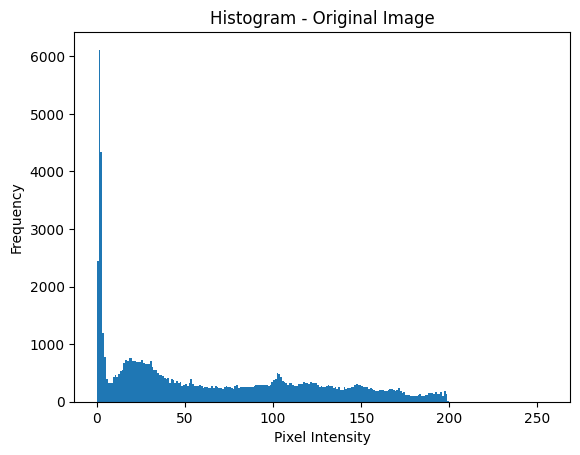

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load the original image (replace 'your_image.jpg' with the actual image file)
original_image = cv2.imread('original_image.jpg', cv2.IMREAD_GRAYSCALE)

# Calculate and plot histogram
hist_values, bins, _ = plt.hist(original_image.flatten(), bins=256, range=[0,256])

# Display the histogram
plt.title('Histogram - Original Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

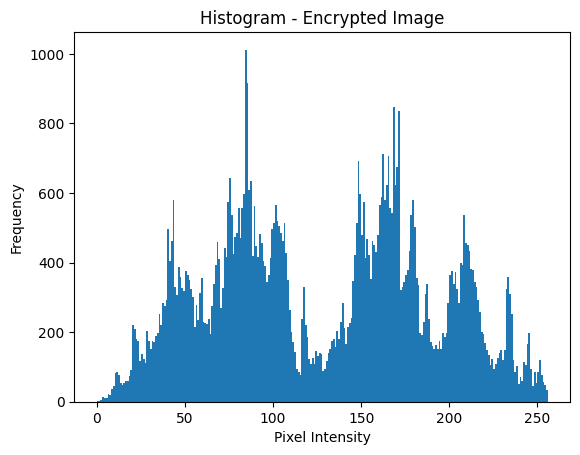

In [11]:
import cv2
import matplotlib.pyplot as plt

# Load the encrypted image (replace 'your_encrypted_image.png' with the actual image file)
encrypted_image = cv2.imread('encrypted.png', cv2.IMREAD_GRAYSCALE)

# Calculate and plot histogram
hist_values, bins, _ = plt.hist(encrypted_image.flatten(), bins=256, range=[0, 256])

# Display the histogram
plt.title('Histogram - Encrypted Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()
